### Main objectives of notebook 

- Demonstrating the time series filters used during preprocessing

We import the necessary libraries; this requires the poetry environment to be set up, and set default plotting commands

In [44]:
import os
import boto3
import numpy as np
import pandas as pd
from src.dataloader import DataLoader
from src.feature_generator import FeatureEngineering
from src.config import PATHS, QUERY, KEYS, MLCONFIG
from src.helpers import (check_s3_bucket, generate_result_from_query,
                         setup_default_clients)
from src.feature_generator import FeatureEngineering
from scipy.signal import savgol_filter, medfilt
import matplotlib.pyplot as plt
import seaborn as sns

style_sheet = PATHS.MISC_DIR / "base.mplstyle"
plt.style.use(style_sheet)
pd.set_option("display.max_columns", 30)
%matplotlib inline

We define a query to access our database

In [20]:
EXAMPLE_QUERY = """
    SELECT
        *,
        case when uuid like '%_walk_%' then true else false end as target
    FROM
        "smu-iot"."microbit"
    WHERE
        seconds IS NOT null 
      AND uuid IN ('licheng_walk_2', 'songhan_fan_1')
    ORDER BY
        uuid, timestamp, seconds
"""

The data is loaded in by calling a `DataLoader` class, which loads our activity data into a suitable structure, and invoking the `.load_data()` method.

In [21]:
session = boto3.setup_default_session(
    region_name=KEYS.AWS_DEFAULT_REGION,
    aws_access_key_id=KEYS.AWS_ACCESS_KEY_ID,
    aws_secret_access_key=KEYS.AWS_SECRET_ACCESS_KEY,
)

dataloader = DataLoader(session=session)

df = dataloader.load_data(EXAMPLE_QUERY, "smu-iot")

There are several ways to set our settings for Feature Engineering. Here, we declare a dictionary of variables

In [22]:
fe_settings = {
    "upload_to_s3": False,
    "apply_smooth_filter": True,
    "apply_median_filter": True,
    "apply_savgol_filter": False,
    "extract_features": True,
    "window_duration": 4,
    "step_seconds": 0.07
}

We can load the settings into our `FeatureEngineering` class, and call a `.fit_transform()` method to retrieve the processed X and y

In [23]:
fe = FeatureEngineering(**fe_settings)
X, y = fe.fit_transform(df, df.uuid)

Applying smoothing


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.80it/s]


Based on this [paper](https://ieeexplore.ieee.org/document/8672772), we explored two main filters to apply during our Feature Engineering process

* Spike Removal
    * Median filter - remove outlier data
* Noise Removal 
    * Savitzky-Golay smoothing filter

In [43]:
df.uuid.unique()

<StringArray>
['licheng_walk_2', 'songhan_fan_1']
Length: 2, dtype: string

We can set up the variables for applying the filters below

In [41]:
WINDOW_DURATION = 4
STEP_SECONDS = 0.07
WINDOW_N = int(WINDOW_DURATION / STEP_SECONDS)
BASE_FEATURES = ["accel_x", "gyro_x", "accel_y", "gyro_y", "accel_z", "gyro_z"]
POST_FEATURE_NAMES = [f"{col}_post" for col in BASE_FEATURES]

Create a copy of the data and sort by timestamp

In [75]:
df_median_filter = df.copy(deep=True)
df_median_filter = df_median_filter.sort_index().reset_index(drop=True)
df_sg_filter = df_median_filter.copy(deep=True)

The median filter smooths our signal within each time window, resulting in smoother peaks and troughs

In [69]:
for item in df_median_filter["uuid"].unique():
    start_idx = df_median_filter.query(f"uuid == '{item}'").index[0]
    end_idx = df_median_filter.query(f"uuid == '{item}'").index[-1]

    for idx in range(start_idx, end_idx, WINDOW_N):
        next_idx = min(idx + WINDOW_N - 1, end_idx)
        df_median_filter.loc[idx:next_idx, POST_FEATURE_NAMES] = (
            df_median_filter.loc[idx:next_idx, BASE_FEATURES]
            .apply(medfilt, axis=0)
            .values
        )

We can plot the data out to see the effects of the median filter

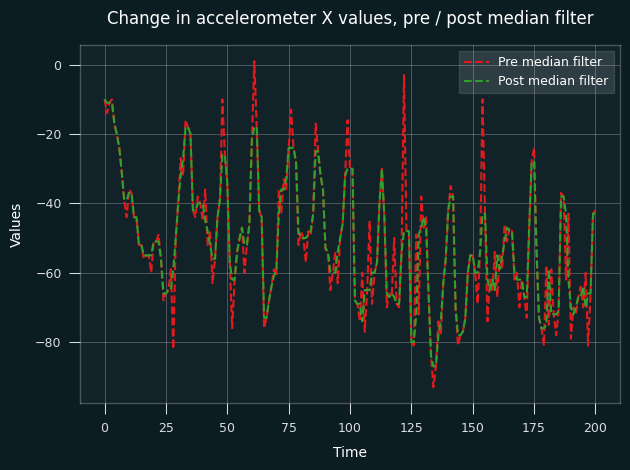

In [74]:
sns.lineplot(
    data=df_median_filter.query("uuid == 'licheng_walk_2'").loc[:200, "accel_x"],
    linestyle="--", 
    color=sns.color_palette()[0],
    label="Pre median filter"
)
sns.lineplot(
    data=df_median_filter.query("uuid == 'licheng_walk_2'").loc[:200, "accel_x_post"],
    linestyle="--", 
    color=sns.color_palette()[1],
    label="Post median filter"
)
plt.title(label="Change in accelerometer X values, pre / post median filter")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show() 

We can similarly apply the Savitzky-Golay filter and examine the filter's effects

In [81]:
for item in df_sg_filter["uuid"].unique():
    start_idx = df_sg_filter.query(f"uuid == '{item}'").index[0]
    end_idx = df_sg_filter.query(f"uuid == '{item}'").index[-1]

    for idx in range(start_idx, end_idx, WINDOW_N):
        window_length = min(next_idx - idx, 20)
        polyorder = window_length // 2
        df_sg_filter.loc[idx:next_idx, POST_FEATURE_NAMES] = (
            df_sg_filter.loc[idx:next_idx, BASE_FEATURES]
            .apply(
                savgol_filter,
                window_length=window_length,
                polyorder=polyorder,
                axis=0,
            )
            .values
        )

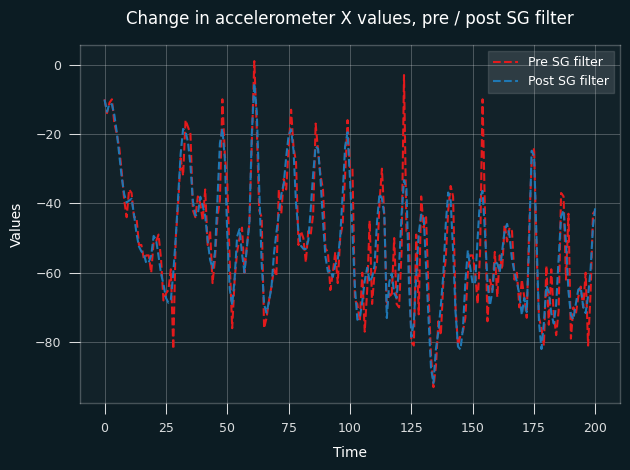

In [80]:
sns.lineplot(
    data=df_sg_filter.query("uuid == 'licheng_walk_2'").loc[:200, "accel_x"],
    linestyle="--", 
    color=sns.color_palette()[0],
    label="Pre SG filter"
)
sns.lineplot(
    data=df_sg_filter.query("uuid == 'licheng_walk_2'").loc[:200, "accel_x_post"],
    linestyle="--", 
    color=sns.color_palette()[3],
    label="Post SG filter"
)
plt.title(label="Change in accelerometer X values, pre / post SG filter")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show() 